# Capstone Project: Create a user authentification model for phone sensors

In this project, I will analyze phone sensor data from build-in accelerator and gyroscopy and use supervised learning techniques to perform user authentification to discriminate user and imposter. The data were generated in the lab by Gary M. Weiss from 
Department of Computer and Information Science of Fordham University. Although it is not represent a real-life data, it will help us to establish the methods to analyze such dataset and project future use for larger dataset. 

In [181]:
# import libraries here
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob2
import tsfel
import random
from time import gmtime, strftime
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

### Step 1: Data organization
Because raw data for each subject were saved as an individual file, here I combine raw data for each sensor for analysis

In [2]:
# A function to combine all txt files in the folder
def combine_txt(in_path, outfile_name, out_path):
    os.chdir(in_path)
    filenames = glob2.glob('*.txt') 
    with open(out_path + '/'+ outfile_name+'.txt', 'w') as f:
        for file in filenames:
            with open(file) as infile:
                f.write(infile.read()+'\n')     

In [ ]:
#combine txt for phone accelorator data
os.chdir('C:\\Users\\tongx\\Desktop\\sally_data_courses\\CKME136\\wisdm-dataset\\raw')
in_path = ('./phone/accel')
outfile_name = ('phone_accel')
out_path = ('C:\\Users\\tongx\\Desktop\\sally_data_courses\\CKME136\\wisdm-dataset\\raw\\combined')
combine_txt(in_path, outfile_name, out_path)

In [ ]:
#combine txt for phone gyroscope data 
os.chdir('C:\\Users\\tongx\\Desktop\\sally_data_courses\\CKME136\\wisdm-dataset\\raw')
in_path = ('./phone/gyro')
outfile_name = ('phone_gyro')
combine_txt(in_path, outfile_name, out_path)

### Step 2: investigate data quanlity for each sensor

In [5]:
# Define a function to summarize the balance of activity data in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(['activity']).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Activity=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))
 

In [47]:
# define a function to subsest data for a specific activity
def subset_data_for_activity(sub_dt, activity, axis):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_dt)) if sub_dt.iloc[i, 1]==activity]
    # return the selected samples
    return sub_dt[axis].iloc[ix]

# plot histograms for multiple activities for one subject
def plot_activity_histograms(sub_dt, n, axis):
    plt.figure(figsize = (18.5, 20.5))
    # get unique subjects
    activities = sub_dt.activity.unique()
    xaxis = None
    for k in range(n):
        activity_id = activities[k]
        # get data for one subject
        subX = subset_data_for_activity(sub_dt, activity_id, axis)
        ax = plt.subplot(n, 1, k+1, sharex=xaxis)
        #ax.set_xlim(-1,1)
        plt.hist(subX, bins=100)
    plt.show()

In [48]:
#define a function to subset data for a specific subject
def subset_data_for_subject(sub_dt, subjectID, axis):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_dt)) if sub_dt.iloc[i, 0]==subjectID]
    # return the selected samples
    return sub_dt[axis].iloc[ix]

# plot histograms for a single activity for different subjects
def plot_subject_histograms(sub_dt, n, axis):
    plt.figure(figsize = (18.5, 20.5))
    # get unique subjects
    subjectIDs = sub_dt.subjectID.unique()
    xaxis = None
    for k in range(n):
        subjectID = subjectIDs[k]
        # get data for one subject
        subX = subset_data_for_subject(sub_dt, subjectID, axis)
        ax = plt.subplot(n, 1, k+1, sharex=xaxis)
        #ax.set_xlim(-1,1)
        plt.hist(subX, bins=100)
    plt.show()

In [7]:
# define a function to plot a histogram to see the districution each axis data
def plot_axis_data(sub_dt, axis):
    plt.figure(figsize=[6,4])
    n, bins, patches = plt.hist(x=pl_dt[axis], bins=100, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.show()

### 2.1 inspect phone accelerator data

In [25]:
os.chdir('C:\\Users\\tongx\\Desktop\\sally_data_courses\\CKME136\\wisdm-dataset\\raw\\combined')
phone_accel = pd.read_csv('phone_accel.txt', sep = ',', header = None)
phone_accel.columns = ['subjectID', 'activity', 'timeStamp', 'x_axis', 'y_axis', 'z_axis']
phone_accel.iloc[:,np.r_[5]] = phone_accel.iloc[:,np.r_[5]].replace(';',"", regex=True).astype(float)

In [26]:
print(phone_accel.head())
phone_accel.shape

   subjectID activity        timeStamp    x_axis     y_axis    z_axis
0       1600        A  252207666810782 -0.364761   8.793503  1.055084
1       1600        A  252207717164786 -0.879730   9.768784  1.016998
2       1600        A  252207767518790  2.001495  11.109070  2.619156
3       1600        A  252207817872794  0.450623  12.651642  0.184555
4       1600        A  252207868226798 -2.164352  13.928436 -4.422485


(2182596, 6)

In [93]:
phone_accel.head()

,subjectID,activity,timeStamp,x_axis,y_axis,z_axis,time_ms
0,1600,A,252207666810782,-0.364761,8.793503,1.055084,1
1,1600,A,252207717164786,-0.879730,9.768784,1.016998,51
2,1600,A,252207767518790,2.001495,11.109070,2.619156,101
3,1600,A,252207817872794,0.450623,12.651642,0.184555,151
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485,201


In [27]:
phone_accel.isnull().sum(axis = 0)

subjectID    0
activity     0
timeStamp    0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

 #### Conclusion: The dataset is pretty clean as there is no NAN in each column; otherwise we may need to fill these missing values before move to the next step

In [28]:
# summarize the total records for each activity to see whether it is balanced.From the results below,
# the percentage of data record for each activity is very close
class_breakdown(phone_accel) 

Activity=1, total=124037, percentage=5.683
Activity=2, total=112608, percentage=5.159
Activity=3, total=119601, percentage=5.480
Activity=4, total=119639, percentage=5.482
Activity=5, total=124735, percentage=5.715
Activity=6, total=115811, percentage=5.306
Activity=7, total=124669, percentage=5.712
Activity=8, total=125557, percentage=5.753
Activity=9, total=123999, percentage=5.681
Activity=10, total=109444, percentage=5.014
Activity=11, total=124111, percentage=5.686
Activity=12, total=117353, percentage=5.377
Activity=13, total=128373, percentage=5.882
Activity=14, total=121324, percentage=5.559
Activity=15, total=127470, percentage=5.840
Activity=16, total=120700, percentage=5.530
Activity=17, total=122866, percentage=5.629
Activity=18, total=120299, percentage=5.512


### I tried to convert timestamp to readable time format, however, there seems something wrong with the timestamp. All data were converted to sometime in 1970, so I add another colun 'time_ms' to count the time (the data is collected every 50 ms, and ms is for milliseconds) .

In [29]:
# something wrong with timeStamp, convert to milliseconds (ms)
phone_accel['time_ms'] = range(1, 1 + len(phone_accel) * 50, 50)

In [30]:
phone_accel.head()

,subjectID,activity,timeStamp,x_axis,y_axis,z_axis,time_ms
0,1600,A,252207666810782,-0.364761,8.793503,1.055084,1
1,1600,A,252207717164786,-0.879730,9.768784,1.016998,51
2,1600,A,252207767518790,2.001495,11.109070,2.619156,101
3,1600,A,252207817872794,0.450623,12.651642,0.184555,151
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485,201


Text(0, 0.5, '')

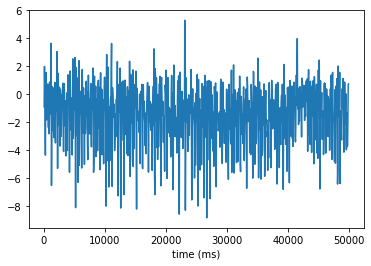

In [31]:
# choose phone accelerator data for subject 1600 to see the data distribution
pl_dt = phone_accel[phone_accel['subjectID'] == 1600]
plt.plot('time_ms', 'x_axis', data=pl_dt[1:1000])
plt.xlabel('time (ms)')
plt.ylabel('')

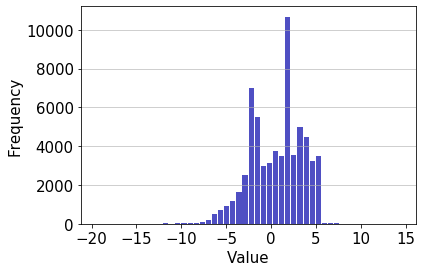

In [32]:
plot_axis_data(pl_dt, 'x_axis')

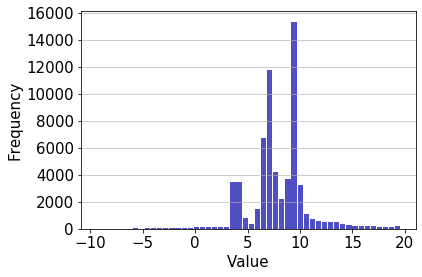

In [33]:
plot_axis_data(pl_dt, 'y_axis')

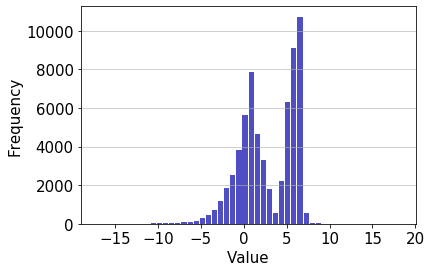

In [34]:
plot_axis_data(pl_dt, 'z_axis')

### From the histograms above for x, y, z axis, we found that the data distribution is different; Most data of y axis is between 0-15, while data of x and y axises are between -5 and 5. 

### 2.2 inspect data for phone gyroscope

In [35]:
phone_gyro = pd.read_csv('phone_gyro.txt', sep = ',', header = None)
phone_gyro.columns = ['subjectID', 'activity', 'timeStamp', 'x_axis', 'y_axis', 'z_axis']
phone_gyro.iloc[:,np.r_[5]] = phone_gyro.iloc[:,np.r_[5]].replace(';',"", regex=True).astype(float)

In [36]:
print(phone_gyro.head())
phone_gyro.shape

   subjectID activity        timeStamp    x_axis    y_axis    z_axis
0       1600        A  252207918580802 -0.853210  0.297226  0.890182
1       1600        A  252207968934806 -0.875137  0.015472  0.162231
2       1600        A  252208019288809 -0.720169  0.388489 -0.284012
3       1600        A  252208069642813 -0.571640  1.227402 -0.241669
4       1600        A  252208119996817 -0.380493  1.202835 -0.213135


(3608635, 6)

In [37]:
phone_gyro.isnull().sum(axis = 0)

subjectID    0
activity     0
timeStamp    0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [38]:
# summarize the total records for each activity to see whether it is balanced.From the results below,
# the percentage of data record for each activity is very close
class_breakdown(phone_gyro) 

Activity=1, total=203919, percentage=5.651
Activity=2, total=200252, percentage=5.549
Activity=3, total=197857, percentage=5.483
Activity=4, total=202370, percentage=5.608
Activity=5, total=202351, percentage=5.607
Activity=6, total=194540, percentage=5.391
Activity=7, total=202622, percentage=5.615
Activity=8, total=202408, percentage=5.609
Activity=9, total=197905, percentage=5.484
Activity=10, total=197844, percentage=5.483
Activity=11, total=202395, percentage=5.609
Activity=12, total=197915, percentage=5.484
Activity=13, total=202625, percentage=5.615
Activity=14, total=198756, percentage=5.508
Activity=15, total=202331, percentage=5.607
Activity=16, total=197894, percentage=5.484
Activity=17, total=202330, percentage=5.607
Activity=18, total=202321, percentage=5.607


In [40]:
# something wrong with timeStamp, convert to milliseconds (ms)
phone_gyro['time_ms'] = range(1, 1 + len(phone_gyro) * 50, 50)

Text(0, 0.5, '')

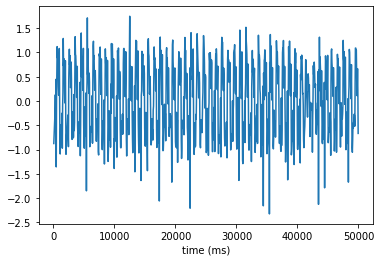

In [41]:
# choose phone accelerator data for subject 1600 to see the data distribution
pl_dt = phone_gyro[phone_gyro['subjectID'] == 1600]
plt.plot('time_ms', 'x_axis', data=pl_dt[1:1000])
plt.xlabel('time (ms)')
plt.ylabel('')

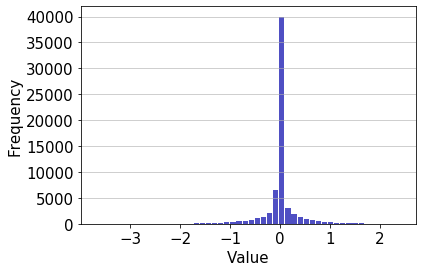

In [42]:
plot_axis_data(pl_dt, 'x_axis')

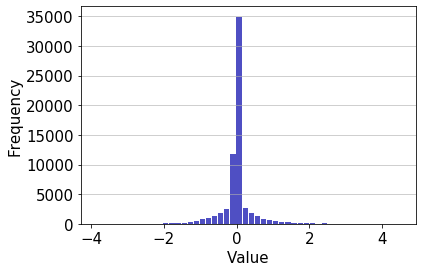

In [43]:
plot_axis_data(pl_dt, 'y_axis')

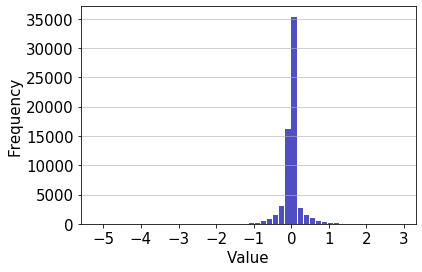

In [45]:
plot_axis_data(pl_dt, 'z_axis')

#### From the histograms above for x, y, z axis, we found that the phone gyroscope data are squeezed to a range around 0. 

### 2.3 To show x axis data for 18 activities for subject 1600

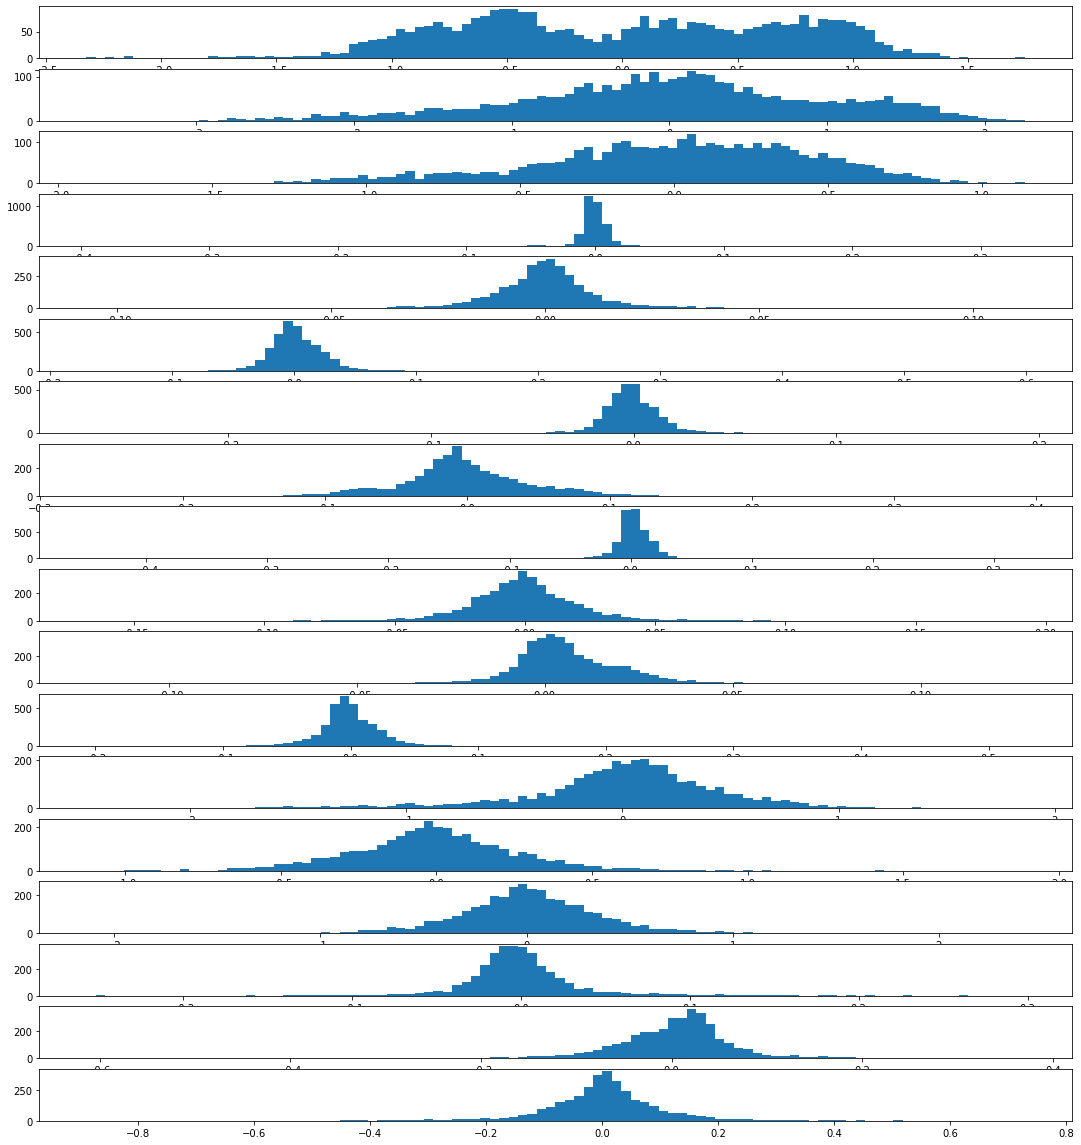

In [49]:
plot_activity_histograms(pl_dt, 18, 'x_axis')

### 2.4 To show the data distribution for each activity for subject 1600

In [50]:
pl_dt = phone_accel[phone_accel['activity'] == "A"]

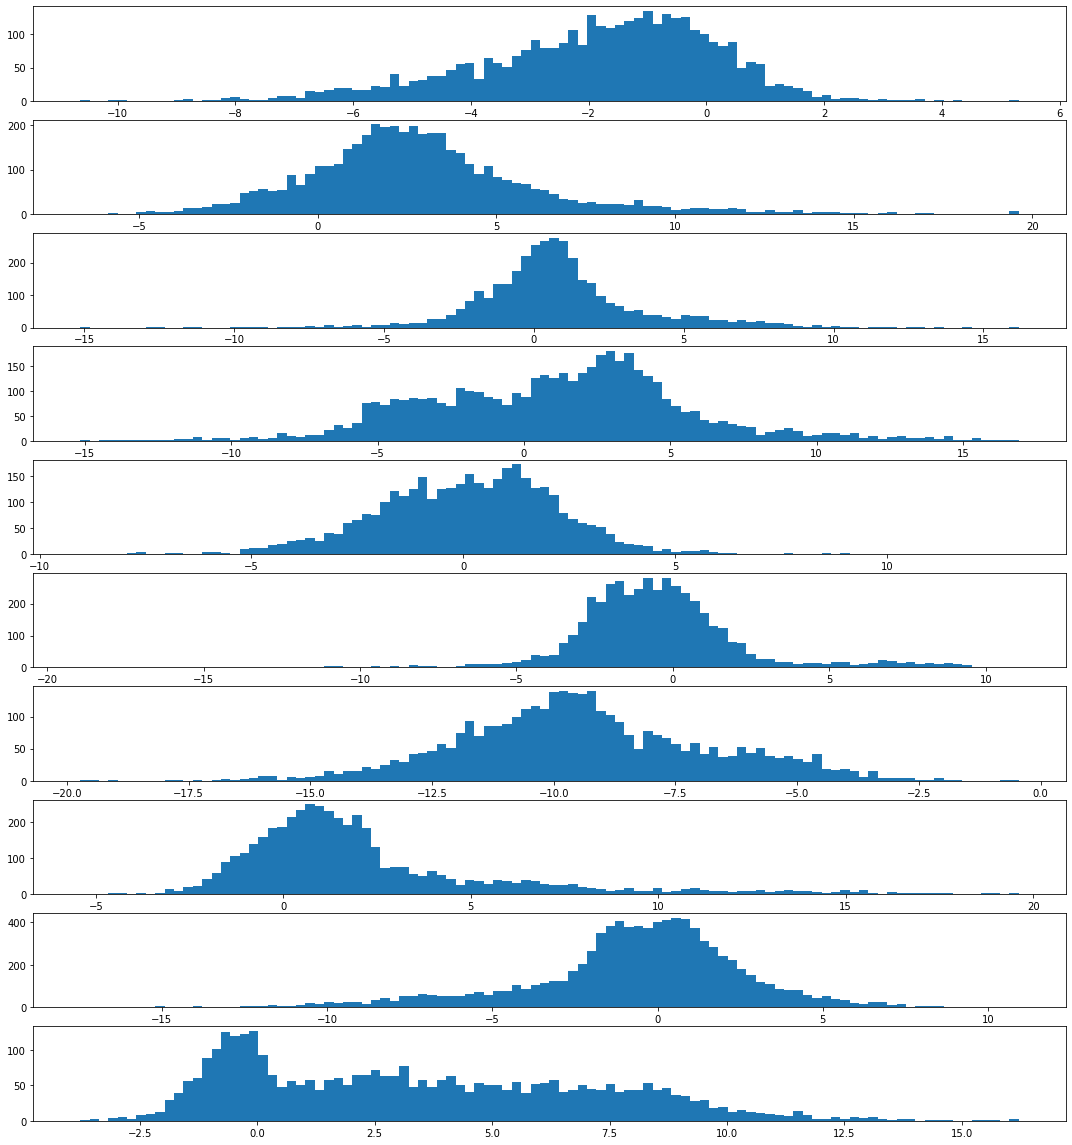

In [51]:
plot_subject_histograms(pl_dt, 10, 'x_axis')

### 3. Reduce the noise of the data using moving average filter, and the signal in the first and the last 5 seconds were removed

In [2]:
#os.chdir('C:\\Users\\tongx\\Desktop\\sally_data_courses\\CKME136\\wisdm-dataset\\raw\\combined')
os.chdir('C:\\Users\\ZZJ\\Desktop\\CMKE136')

#read in phone accelerator data and rename the columns
phone_accel = pd.read_csv('phone_accel.txt', sep = ',', header = None)
phone_accel.columns = ['subjectID', 'activity', 'timeStamp', 'phone_accel_x', 'phone_accel_y', 'phone_accel_z']
#phone_accel['source'] = 'phone_accel'
phone_accel.shape

(4804403, 6)

In [3]:
#read in phone gyroscope data and rename the columns
phone_gyro = pd.read_csv('phone_gyro.txt', sep = ',', header = None)
phone_gyro.columns = ['subjectID', 'activity', 'timeStamp', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']
#phone_gyro['source'] = 'phone_gyro'
phone_gyro.shape

(3608635, 6)

In [4]:
#Because the phone accelerator and gyroscope data are acquired at the same time, so merge these two dataframes need to match the subjectID, activity and timestamp
phone_data = pd.merge(phone_accel, phone_gyro, on = ['subjectID', 'activity', 'timeStamp']) #merge two dataframes
phone_data.iloc[:,np.r_[5,8]] = phone_data.iloc[:,np.r_[5,8]].replace(';',"", regex=True).astype(float) #remove ";" at the end of each row


In [36]:
#inspect the data quantity for a specific subject and activity
phone_data[(phone_data['activity'] == 'B') & (phone_data['subjectID'] == 1600)].shape

(3569, 9)

In [49]:
# Define a function to apply moving average filter to reduce the noise 
def denoise_filter(data, activities):
    start_time = time.time()
    data_denoised = pd.DataFrame([])
    
    #get unique subject ID
    subjects = data.iloc[:, 0].unique()
    print(subjects.shape)
    
    #Step 1: apply denoosing step to each activity in each subject
    for subject in subjects:
        for activity in activities:
            data_sub = data[(data['activity'] == activity) & (data['subjectID'] == subject)]
            nrow = data_sub.shape[0]

            for i in range(1, nrow-2):
                data_sub['phone_accel_x_denoise'] = data_sub.iloc[:,3].rolling(window=3).mean().round(5)
                data_sub['phone_accel_y_denoise'] = data_sub.iloc[:,4].rolling(window=3).mean().round(5)
                data_sub['phone_accel_z_denoise'] = data_sub.iloc[:,5].rolling(window=3).mean().round(5)
                data_sub['phone_gyro_x_denoise'] = data_sub.iloc[:,6].rolling(window=3).mean().round(5)
                data_sub['phone_gyro_y_denoise'] = data_sub.iloc[:,7].rolling(window=3).mean().round(5)
                data_sub['phone_gyro_z_denoise'] = data_sub.iloc[:,8].rolling(window=3).mean().round(5)


            #step 2: remove the records of the first and the last 5 seconds from the data
            data_sub = data_sub.iloc[100:(data_sub.shape[0]-100),:]

            #step 3: append the filtered data to new dataframe
            data_denoised = data_denoised.append(data_sub)
            #print(data_denoised.shape)
    print(time.time() - start_time)  #calculate processing time   
    return data_denoised


In [45]:
# I found that some activities, such sitting and writing have very flat signals recorded by cell phone, also because it takes really
# long time to process all activities, to simplify the process, I choose 5 activities that might have stronger signal flunctuation.
activities = ['A', 'B', 'C', 'O', 'P']
phone_data_sub = phone_data[phone_data['activity'].isin(activities)]
phone_data_sub.shape

(763572, 9)

In [47]:
phone_data.shape

(2909149, 9)

In [50]:
#apply denoise step to the data
phone_data_denoised = denoise_filter(phone_data_sub, activities)

(50,)


E:\anaconda\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\anaconda\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\anaconda\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

5045.123564481735


In [51]:
phone_data_denoised.shape

(722405, 15)

In [53]:
#write the data into a csv file
phone_data_denoised.to_csv('phone_data_denoised.csv', sep = ',')

### Step 4: Feature extraction

In [83]:
# Define a function to do feature extraction for each activity in each individual
def feature_extraction(data):
    data_feature_extracted = pd.DataFrame([])
    activities = data.iloc[:, 1].unique()
    print(activities)
    #activities = ['A', 'B', 'C', 'O', 'P']
    subjects = data.iloc[:, 0].unique()
    print(subjects.shape)
    i = 0
    for subject in subjects:
        #data_sub = data[data.iloc[:, 0] == subject]
    # loop over each activity
        for activity in activities:
            data_sub = data[(data['activity'] == activity) & (data['subjectID'] == subject)].iloc[:, 9:15]
            print(data_sub.head(1))
            data_sub[data_sub == 0] = 0.001
            print(data_sub.eq(0).any().any())

            # feature extraction by functions in tsfel package
            features = tsfel.get_features_by_domain()                                                                               
            try:
                data_sub_features = tsfel.time_series_features_extractor(features, data_sub, window_size=200, window_spliter=True, overlap=0.5, fs = 20)
            except:
                print("Unexpected error, ignore it...")
                i = i+1

            data_sub_features['activity'] = activity
            data_sub_features['subjectID'] = subject
            
            data_feature_extracted = data_feature_extracted.append(data_sub_features)
        print(i) #calculate how many error messages

    return data_feature_extracted

In [86]:
phone_data_feature_extracted = feature_extraction(phone_data_denoised)

['A' 'B' 'C' 'O' 'P']
(50,)
     phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
100               -3.62201               14.18464               -3.23027   

     phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
100              -0.07976              -0.12068               0.67332  
False
*** Feature extraction started ***



*** Feature extraction finished ***
      phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
3669               -0.36569                4.65731               -0.42146   

      phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
3669               0.24834               0.04584                0.1021  
False
*** Feature extraction started ***



*** Feature extraction finished ***
      phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
7238               -1.37274                7.25575                0.10026   

      phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
7238              -0.06782               0.47606              -0.25333  
False
*** Feature extraction started ***



*** Feature extraction finished ***
       phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
46492               -1.57431               11.32278               -1.46742   

       phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
46492              -0.38852                1.3368              -0.20365  
False
*** Feature extraction started ***



*** Feature extraction finished ***
       phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
50061               -0.50576                9.87118                0.78517   

       phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
50061              -0.12104               0.13813              -0.01396  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
       phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
64338                2.90896               12.39458                8.84358   

       phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
64338              -0.14017              -1.11329              -0.02432  
False
*** Feature extraction started ***



*** Feature extraction finished ***
       phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
68850                 2.3543                -6.4827                -4.0466   

       phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
68850               0.19681              -1.99986               0.73858  
False
*** Feature extraction started ***



*** Feature extraction finished ***
       phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
73360                1.84473               -9.89863               -0.44233   

       phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
73360              -1.23855               -2.2928                0.7867  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
122975                3.48157                9.60454                3.16015   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
122975              -0.07839               0.51887              -0.37373  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
127485                5.30196                8.52196                0.84056   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
127485               0.62282               0.10093              -0.38678  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
145528               -0.38566               -8.61067                 -0.341   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
145528              -1.92448               1.20303               0.31348  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
149097                2.95469              -11.52228                0.71143   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
149097              -0.69843                0.2339              -0.10756  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
152666                1.14149              -12.35975               -0.69874   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
152666               1.89375               0.49025               2.67925  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
178358                2.67679               -9.01662               -1.46057   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
178358              -0.95217               1.37512              -0.02265  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
181927               -2.01163               -9.19942                 2.3518   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
181927               -0.3447               0.24648              -0.26113  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
192627                0.99639               13.86103                 5.9474   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
192627               0.80277              -0.01012               0.24874  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
197137                0.55146               16.83423               -4.18846   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
197137               1.18999               1.75511              -1.33176  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
201648               -3.43488                 6.8119                1.80802   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
201648               2.68021              -3.39251              -1.06065  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
251260               -0.79069                9.48762               -0.17358   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
251260               0.02823              -0.11105               0.19459  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
255770                0.68015               11.23519                2.00215   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
255770              -0.36796               0.83375               0.01465  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
273813                3.16452                 11.509                 3.5199   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
273813               0.41487                 0.315              -0.30267  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
277382               -0.74017                3.54274               -0.70479   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
277382               -1.4623               0.38541                0.3891  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
280951               -0.17761               12.43728                0.38483   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
280951              -2.64879               0.56346               0.28493  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
320211                 1.2973                9.10226                2.31809   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
320211              -0.00647               0.28393              -0.05157  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
323780               -1.26706                9.16566                1.38984   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
323780               0.32279               -0.0813               0.08618  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
338055               -2.07238               12.69067               -1.20568   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
338055               0.22308              -0.46064              -0.36521  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
342566               -0.65741               -0.94431               -0.16779   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
342566                0.3597              -0.70547               0.51328  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
347076                3.11585                5.22894                3.99133   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
347076               0.91124              -0.20577              -0.75181  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
396681               -1.55184                9.31285                0.81842   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
396681               1.14844              -0.61812               0.59912  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
401191                 0.7428                9.86551               -0.33519   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
401191              -0.18651              -0.21137               0.11203  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
419231               -6.94256               -2.70329               -1.23899   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
419231               0.67994               0.10601               0.06819  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
422799                -9.3677               -4.14956               -1.64153   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
422799              -0.73233              -0.17442              -0.32968  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
426368               -8.04456               -1.72741                0.24661   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
426368               0.05356               0.40116              -0.76203  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
465623               -8.43812                0.22023                0.42321   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
465623               0.50632              -1.93802               0.35201  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
469193               -8.93805               -0.98759                 1.7126   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
469193                 0.039              -0.00604               0.00532  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
483465                2.43231               10.00996               -1.24259   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
483465              -1.41822              -0.46472              -0.08939  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
487976               -3.88679                 6.1112                2.69946   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
487976              -2.31731              -0.29543              -0.02583  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
492486               -5.50407                  7.184                1.84334   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
492486                -0.778              -1.47113               0.73876  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
537595                0.67616               -9.69013                2.13164   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
537595              -0.09516               0.07688               0.10164  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
542105                4.52085                -8.7961                1.28269   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
542105               0.17577                0.1368              -0.04607  
False
*** Feature extraction started ***



*** Feature extraction finished ***
0
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
560148               -2.50722               -9.54696               -1.93323   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
560148               0.29651              -0.01083                -0.869  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
4
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
602972               -1.95994               -4.49126                1.68642   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
602972               0.75222              -0.87343               0.07257  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
606541                3.62168              -11.11415               -0.07162   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
606541               0.69953              -0.57987               0.20683  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
643632                1.90344              -10.81565               -3.27588   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
643632               1.40083               0.23071               0.99562  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
647201                4.14278               -8.44101               -1.50508   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
647201              -0.30504               1.01273              -0.02864  
False
*** Feature extraction started ***



*** Feature extraction finished ***
5
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
661478                4.75355                 7.2638                -0.6058   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
661478                 0.254               0.48505              -0.54556  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
665047               -2.28347               12.20161                -3.0819   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
665047              -1.69031              -1.02298               3.96338  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
668317                0.63691                6.60875                0.09867   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
668317               0.45841                0.3425               -1.3021  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
7
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
714711               -1.46107              -10.32026                1.99493   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
714711               3.18821               0.91809               0.06402  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
718279                -9.7377              -15.60473                2.12515   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
718279              -0.04389               1.38701               0.28451  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
721848                0.64153               -8.71183                 1.0869   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
721848               0.12171               0.80068               0.49773  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
761104                3.29694               -8.89933                0.62608   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
761104              -0.06644               0.27219               -0.0545  
False
*** Feature extraction started ***



*** Feature extraction finished ***
8
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
775380               -3.93251               -5.58578                 -0.174   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
775380              -0.58073              -0.32467              -0.35299  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
778949               -2.56466               -2.26076               -1.43892   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
778949               1.01248              -2.03401               -1.5245  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
782518               -3.16486               -6.25291               -3.22076   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
782518              -0.02702              -0.28293              -0.95107  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
821776                 2.8466                -9.2582               -0.56797   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
821776              -0.01231              -0.34044                0.0029  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
825345               -9.34763               -3.06285                1.04346   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
825345                0.0141               0.00107               0.00448  
False
*** Feature extraction started ***



*** Feature extraction finished ***
8
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
839611               -2.13064               13.75229               -0.94391   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
839611              -0.46428              -0.10839              -0.29597  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
844121               -1.89661               12.57914                0.24999   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
844121               2.00412               0.49925               0.12526  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
848631               -4.17429               12.91851               -0.20969   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
848631              -1.52342              -0.25762                0.0245  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
898243               -0.70469                9.43774                2.31439   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
898243              -0.20782              -0.93069              -0.16299  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
902753               -0.61232                9.22725               -0.67836   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
902753               0.47165               0.20116               0.12197  
False
*** Feature extraction started ***



*** Feature extraction finished ***
8
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
920793               -0.29778               13.12151               -1.42264   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
920793               0.67005              -3.06867               0.19388  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, igno


*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
942801                2.81635                1.33576               -9.67939   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
942801                -0.397              -1.20516              -0.13408  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
946370                1.74406              -17.50345               -5.03059   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
946370               1.91835              -0.58357               0.09562  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
985629                1.90739               -10.3598               -0.39752   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
985629               -0.0122               0.75682               0.55642  
False
*** Feature extraction started ***



*** Feature extraction finished ***
        phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
989197                 5.1534               -8.57271               -2.28696   

        phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
989197               0.55833              -1.11767              -0.44514  
False
*** Feature extraction started ***



*** Feature extraction finished ***
12
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1003473                5.62856               -8.21318                1.34444   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1003473               0.53561               1.21008              -0.36929  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, igno


*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1036036                2.53664              -16.79532               -5.09398   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1036036              -1.17418               1.70227              -0.07568  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1039605               -5.23088                -6.3705               -2.20876   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1039605               0.83676              -0.33295               1.26285  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1078863               -4.31622               -8.32504                2.51374   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1078863               0.28741               0.91923               0.05759  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1082432                0.13415                2.01531               12.25173   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1082432              -0.70023               2.92453               1.43179  
False
*** Feature extraction started ***



*** Feature extraction finished ***
16
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1096706               -7.88713              -12.47228               -3.69923   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1096706               0.97676               3.25014               3.18091  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1100275               14.87408                0.21651                6.58784   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1100275               4.72727              -5.80695               2.34532  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1103844               -0.78441                -7.8194                3.52709   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1103844               1.03151              -0.19693              -0.01745  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1141166                -8.8554               -6.34294               -2.22931   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1141166              -0.09299               0.50933              -0.02168  
False
*** Feature extraction started ***



*** Feature extraction finished ***
17
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1155442               -0.07502               -8.66302                -0.8651   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1155442              -1.30992               0.36539              -0.90974  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1159952                0.04729               -7.09182               -3.15835   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1159952               1.51161              -1.12172               1.73354  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1164463               -4.01887               -8.18637                2.60609   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1164463              -0.90903                0.6633              -0.23365  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1214084               -4.56315               -8.97566                 1.4441   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1214084              -0.06498              -0.27839               0.06214  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1218594               -5.15531               -8.93337                0.91738   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1218594               -0.5163              -0.39912              -0.00959  
False
*** Feature extraction started ***



*** Feature extraction finished ***
17
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1236637                3.26512                8.54168               -2.39443   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1236637               0.66026               1.03347              -0.05188  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1240205                2.52797                7.53087               -2.35586   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1240205               0.09188              -0.92135               0.36174  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1243774                2.12021                -5.7707               -4.37894   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1243774              -1.56894               2.73518               0.21248  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1261620               -7.24664                3.69747               -1.09166   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1261620               1.17951              -2.96667               2.45926  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
18
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1266692                1.70387                 0.6588                11.3148   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1266692              -0.54861               0.09339               0.75456  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1271204               -0.00998               12.18788                1.78009   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1271204               -1.1828               4.35018              -0.88026  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1275714                0.50238               12.91532               -1.55503   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1275714              -0.76983               -0.1115              -0.17257  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1325325                4.15753                8.63229                -1.4437   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1325325               -0.2933               0.10298              -0.25105  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1329836                5.41748                8.40205                5.48432   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1329836               0.33449               0.09694               0.15695  
False
*** Feature extraction started ***



*** Feature extraction finished ***
18
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1347876               -0.49634               -5.24491                1.37068   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1347876               1.18413              -1.25621               0.45893  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1351445               -0.09461              -15.14687                3.53316   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1351445               1.26142              -0.31135               0.93252  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1355013                1.03489               -8.08943                 2.1493   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1355013               1.19375              -0.15053              -0.05107  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1394272               -5.22341                -8.5062                2.05733   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1394272               0.31356               1.01285               0.09497  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1397842               -2.67233                -9.2106                 0.4468   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1397842               0.04627              -0.05931               0.03738  
False
*** Feature extraction started ***



*** Feature extraction finished ***
18
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1412119                2.03706               -9.51637               -0.03056   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1412119               0.89584               0.26575               0.08171  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1415688                2.18596               -8.30124               -5.76186   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1415688               1.83951               -0.1829               1.11409  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1419257               -0.56058               -3.73682               -4.35866   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1419257              -0.62344              -0.55541              -0.13177  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1447809               -0.39098               -9.78569               -0.28533   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1447809              -0.02228              -0.04542              -0.04008  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1451378                -1.4126               -9.49249               -0.26844   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1451378                0.0241              -0.39207               0.00605  
False
*** Feature extraction started ***



*** Feature extraction finished ***
18
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1458517                3.50643               -7.24727               -1.52584   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1458517               0.55674               0.74445               0.43181  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1462083                7.64261               -11.8925               -3.21135   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1462083               1.66158               0.40129               0.59263  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1465651                3.82411                -8.0249               -0.94374   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1465651               0.33558               0.67408              -0.19532  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1504907                3.64771               -8.89355               -0.65451   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1504907               0.03752              -0.14003               -0.0097  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1508476                6.08378               -7.52107               -2.40459   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1508476               0.30332              -0.02303                0.2897  
False
*** Feature extraction started ***



*** Feature extraction finished ***
18
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1522751               -3.99295               -0.39495                3.91674   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1522751              -1.26037              -0.58201              -0.30885  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1543336               -9.35765               -4.90302               -2.03713   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1543336              -0.82915              -0.18165              -0.12942  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1546904                -8.8287                -3.4268               -0.77366   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1546904              -0.24561               0.00164              -0.00203  
False
*** Feature extraction started ***



*** Feature extraction finished ***
20
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1551705               -1.08619               -8.46817                2.19524   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1551705               -0.4391               1.26593               0.23788  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1555274               15.97547              -10.20797                7.01171   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1555274               0.29981               0.50289              -0.16611  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1563688                2.62112               -6.03962                0.88217   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1563688               0.13858                0.5186               0.26853  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1599823                2.15352               -9.25897                2.31172   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1599823              -0.05685               0.01322              -0.04459  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1603388                2.53638                -8.9204                3.69154   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1603388               0.07942               0.03082              -0.07541  
False
*** Feature extraction started ***



*** Feature extraction finished ***
20
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1617663                 7.4778               -7.23084                4.41679   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1617663              -0.05724               0.94021              -0.15812  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
24
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, i


*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
28
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1649079               -7.87245                5.89243               -2.91237   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1649079               0.29844               0.08506                0.2407  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1663355                -0.7376                8.03173                5.77521   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1663355               0.17779              -1.01484                0.7827  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1677635               -5.56512                9.76241               -5.47359   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1677635               0.34237              -0.14865              -0.27749  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1820371               -1.63595                9.72514               -1.32909   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1820371               0.05525              -0.25331                0.0636  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1834647               -5.08573                8.21314               -2.59959   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1834647               0.17305              -0.05111              -0.06983  
False
*** Feature extraction started ***



*** Feature extraction finished ***
28
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1891739               13.12488                2.55079                3.36802   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1891739               0.10147               0.13207              -0.35765  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1895308                9.64143                3.48415               11.47028   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1895308               0.67464              -0.16301               0.06017  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1898877                6.81786                3.69075                7.88273   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1898877              -0.36542              -0.19844               0.53057  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1938133                5.43126                2.02471                 7.6874   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1938133               0.54429              -0.42731               0.08766  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1941702                 8.3277                1.67753                0.79253   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1941702                0.4325               0.74972               0.22052  
False
*** Feature extraction started ***



*** Feature extraction finished ***
28
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1955978                -1.7897                6.48632                3.69284   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1955978               1.66006              -0.97358              -0.80837  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1959546               -5.30444               12.83363                2.89543   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1959546              -3.36244               0.62008               0.63367  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
1963115                1.80087               11.73942                1.83756   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
1963115              -2.63536               0.12267               0.61759  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2002371                3.37308                9.06055               -2.51328   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2002371               0.17941               0.20374              -0.15232  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2005941                3.91194                8.56848               -1.02453   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2005941               0.14765                0.1968               0.02168  
False
*** Feature extraction started ***



*** Feature extraction finished ***
28
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2020216               -0.59166              -13.01757               -1.81495   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2020216               0.76366               0.13612                0.5875  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2023786                0.69613              -17.34652                 1.3948   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2023786               0.86723               1.09945               3.19195  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2027355               -3.18847               -8.41296               -0.90158   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2027355               0.86293               0.01598              -0.45472  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2066614                0.65254               -9.20018                3.85016   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2066614               0.52668               0.65516              -0.38992  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2070183               -2.03993               -9.60255                0.08745   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2070183               0.06449               0.48864               0.07616  
False
*** Feature extraction started ***



*** Feature extraction finished ***
28
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2084460               -2.26982               -9.44979               -0.90508   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2084460              -0.25421               -2.3609               -0.9564  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2120149               -2.08271               -9.03972               -0.98156   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2120149               0.03421              -0.19225              -0.25164  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2134422               -1.23903               -8.70933               -1.99923   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2134422              -0.85943               1.04677              -0.42896  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2137991                2.79475               -7.47266               -1.39125   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2137991              -2.36244               1.83758               0.24068  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2141560               -1.49099              -10.77204                0.56817   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2141560                0.5891              -1.19458              -0.41617  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2180819                1.52029               -9.12296                1.88773   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2180819               0.42363              -0.44409                -0.012  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2184388               -1.55429               -9.70126               -2.34633   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2184388              -0.70071              -1.34417              -0.01746  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2217846               -5.59106              -11.87745               -0.09114   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2217846               -0.1557              -0.44125              -0.14817  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2221415                -1.3063               -1.54096                2.28693   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2221415               2.02207               0.26779              -0.16714  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2224984               -0.59437               -9.35425                1.86178   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2224984               0.97914               1.57522               0.50023  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2264237                1.62354               -9.47611               -0.73497   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2264237              -0.04762              -0.11296                0.0817  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2267805                4.16291               -8.77412               -0.19804   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2267805              -0.14643                0.2817               -0.0763  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2282081                3.69555               -8.83096               -2.19763   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2282081               1.49593               0.25838              -0.09559  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2285679                8.74652                8.45916               -5.15447   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2285679              -1.00033               0.14369              -2.95014  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2289277                7.11447               -3.46955                1.31626   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2289277                0.3948              -0.09139               0.29537  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2328857               -0.87817                 0.8041              -14.05651   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2328857              -0.81356              -5.84168              -2.05887  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2332455                1.23192               -3.29796               -1.24553   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2332455              -0.77806               1.36624               0.96293  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2346847               10.56412               -0.18804                0.79852   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2346847              -1.33598              -1.84777              -2.97356  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2350446                4.89784               -6.21744               -12.4492   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2350446               2.05618              -3.93356               0.27158  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2354045                7.53864               -0.85523               -1.04582   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2354045              -0.35488               0.07999               1.15293  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2393647               -6.15699              -13.44713               -2.44722   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2393647              -0.69647               0.49155              -1.82059  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2397246               13.43696              -11.59322                2.93893   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2397246              -3.51018               4.72278               5.04184  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2411641                 10.693               -3.32161                 3.2601   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2411641               0.36003              -0.80225              -1.04188  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2415256                9.65871                9.95903               -2.30721   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2415256               0.33092              -1.28801               0.87595  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2418855                11.8925               -1.43657                 0.8276   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2418855               0.11785               0.07658               0.08802  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2458455                0.03322              -11.50339               -3.35507   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2458455              -2.13553               0.60354              -4.65596  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2462054                2.08904               -5.92011                 5.8618   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2462054                 0.278                3.1165               1.00911  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2476447               12.91592               -4.19404               -0.46233   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2476447              -0.07707               -0.2582              -0.11079  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2480046               -0.15562              -16.27758               -4.02091   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2480046              -0.11826              -4.68082                1.0855  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2483645               14.84066               -5.84445               -0.40407   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2483645              -0.36256               0.24816               0.27591  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2523263               -8.18498               -7.53635               -1.54132   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2523263               2.73524              -0.01211               0.95731  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2526862               -3.94405                7.67561               -5.97618   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2526862               1.28044              -0.53658               -0.5227  
False
*** Feature extraction started ***



*** Feature extraction finished ***
31
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2541312               -0.64266                1.30928                2.24892   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2541312              -1.34472              -0.42611              -0.86251  
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_den


*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2574534                1.97669                9.96009                1.09612   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2574534               0.00178              -0.02486              -0.01278  
False
*** Feature extraction started ***



*** Feature extraction finished ***
39
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2579929                3.13987               -6.39231                0.31934   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2579929              -0.84049              -0.53689              -1.46012  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2581829                3.21332               -4.21763               -0.11656   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2581829              -0.98359              -0.14949              -1.26553  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2584024                2.60179              -10.20199                1.66214   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2584024              -0.29508              -1.56487              -0.09339  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2614716                2.23535               -9.14498                 0.3385   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2614716               0.08735               0.04332              -0.11611  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2616913               -2.18346               -10.5796                0.11576   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2616913              -0.56672              -0.27555                0.2056  
False
*** Feature extraction started ***



*** Feature extraction finished ***
39
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2645802               -0.57959                -9.1833                1.55437   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_deno


*** Feature extraction finished ***
43
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2649455               -0.85263                5.50934                9.12183   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2649455              -0.17648              -0.47617              -0.06392  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
47
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, i


*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2707963                8.39267               -4.27664               -4.13698   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2707963               0.13032              -0.49535               0.39131  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2712474                1.60212               -8.65284               -1.43233   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2712474              -1.86563              -1.38307              -0.46943  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2762088                1.28968               -6.24408               -4.65991   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2762088               1.95654              -0.06285               0.57027  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2766598                3.41852               -9.03372               -0.82061   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2766598              -0.08203               0.01669              -0.07031  
False
*** Feature extraction started ***



*** Feature extraction finished ***
52
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2784698                3.25403                6.12407                1.51844   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2784698               0.84156               0.20098               -1.0191  
False
*** Feature extraction started ***



*** Feature extraction finished ***
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
Empty DataFrame
Columns: [phone_accel_x_denoise, phone_accel_y_denoise, phone_accel_z_denoise, phone_gyro_x_denoise, phone_gyro_y_denoise, phone_gyro_z_denoise]
Index: []
False
*** Feature extraction started ***
Unexpected error, ignore it...
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2797613               -2.60738               -8.87435                0.02475   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2797613              -0.11363              -0.26561              -0.05113  
False
*** Feature extraction started ***
Unexpected error, ignore it...
56
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2800325  


*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2804836                1.02033              -15.41168               -3.02288   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2804836              -3.57858              -0.45593              -3.78844  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2809347               -2.20446              -13.27445               -0.40961   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2809347              -0.49215               0.56175              -0.28372  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2858969                5.46157               -9.93434               -1.26873   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2858969              -0.55323               1.66146              -0.35296  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2863479               -2.13982                -5.4937               -4.88078   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2863479               0.62815              -0.50387              -0.14985  
False
*** Feature extraction started ***



*** Feature extraction finished ***
56
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2881524               -8.83363               -3.39853                0.97158   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2881524              -0.82665              -0.59619              -0.05717  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2883482               -0.06307               -7.48843                0.81511   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2883482              -1.26269              -1.19558               1.79533  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2885378              -11.35399               -3.76417               -3.34983   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2885378                 0.049               0.09871              -0.08842  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2899502               -2.62255               -8.55102                2.45569   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2899502               0.10156               0.15801              -0.15269  
False
*** Feature extraction started ***



*** Feature extraction finished ***
         phone_accel_x_denoise  phone_accel_y_denoise  phone_accel_z_denoise  \
2901500                 0.9117               -9.16973                 0.5285   

         phone_gyro_x_denoise  phone_gyro_y_denoise  phone_gyro_z_denoise  
2901500              -0.14204              -2.07478                0.2269  
False
*** Feature extraction started ***



*** Feature extraction finished ***
56


In [87]:
phone_data_feature_extracted.shape

(8188, 1412)

In [88]:
# check if there is any Null value generated
phone_data_feature_extracted.isnull().any(axis=1).sum()

0

In [89]:
#write the data into a csv file
phone_data_feature_extracted.to_csv('phone_data_feature_extracted.csv')

In [90]:
phone_data_feature_extracted.head()

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF Slope,0_ECDF_0,...,5_Wavelet variance_2,5_Wavelet variance_3,5_Wavelet variance_4,5_Wavelet variance_5,5_Wavelet variance_6,5_Wavelet variance_7,5_Wavelet variance_8,5_Zero crossing rate,activity,subjectID
0,721.864333,14.700707,721.864333,5.303055,40.0,160.0,-2.58707,-0.16534,0.234881,0.005,...,0.193725,0.352641,0.434174,0.367005,0.229206,0.114474,0.052758,60.0,A,1600
1,793.235574,15.443177,793.235574,4.733788,40.0,160.0,-2.65057,-0.16534,0.215888,0.005,...,0.163619,0.280563,0.341983,0.291145,0.186457,0.098539,0.050883,56.0,A,1600
2,809.080466,16.010308,809.080466,5.171132,40.0,160.0,-2.71681,-0.29899,0.277288,0.005,...,0.144108,0.237366,0.289026,0.249700,0.165845,0.094759,0.055730,56.0,A,1600
3,896.333227,17.027549,896.333227,4.917758,40.0,160.0,-2.83038,-0.42170,0.233226,0.005,...,0.151301,0.266094,0.332979,0.290483,0.192240,0.107253,0.059908,60.0,A,1600
4,898.825978,17.362586,898.825978,4.701472,40.0,160.0,-2.80038,-0.45198,0.206099,0.005,...,0.152974,0.271872,0.339562,0.295751,0.195821,0.109489,0.059936,60.0,A,1600


### Step 5: Feature selection according to previous publications
Here I used two methods to do the feature selection:
1. Select features according to previous publications
2. Use PCA to reduce the dimension of features

### Method 1: Select features according to previous publications

In [55]:
#define a function to select features
def select_features(data):

    # get activity list
    activities = data['activity'].unique()
    input_file_feature_sel = pd.DataFrame([])
    
    #select features
    features = ['Interquartile range', 'Kurtosis', 'Max', 'Mean', 'Mean absolute deviation', 'Median', 'Median absolute deviation',\
                'Min', 'Root mean square', 'Skewness', 'Standard deviation', 'Variance', 'Mean absolute diff',\
                'Mean diff', 'Signal distance', 'Sum absolute diff', 'Total energy', 'Slope', 'Absolute energy',\
                'Peak to peak distance', 'Entropy']
    prefixes = ['0_', '1_', '2_', '3_', '4_', '5_']
    new_feature_list = []
    for p in prefixes:
        new_feature = [p + f for f in features]
        new_feature_list = new_feature_list + new_feature
        
    data_sub = data[new_feature_list + ['activity', 'subjectID']]
    
    return data_sub

In [52]:
os.chdir('C:\\Users\\tongx\\Desktop\\CMKE136')
phone_data_feature_extracted = pd.read_csv("phone_data_feature_extracted.csv")

In [56]:
phone_data_feature_selected = select_features(phone_data_feature_extracted)
phone_data_feature_selected.head()

,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,...,5_Mean diff,5_Signal distance,5_Sum absolute diff,5_Total energy,5_Slope,5_Absolute energy,5_Peak to peak distance,5_Entropy,activity,subjectID
0,1.942422,-0.449912,1.64871,-1.436276,1.025996,-1.425830,0.965335,-5.15064,1.899821,-0.226015,...,-0.000788,204.687091,41.89655,2.036635,-0.000146,20.264522,1.43924,0.998692,A,1600
1,2.114133,-0.585650,1.64871,-1.494783,1.097896,-1.490650,1.065980,-5.15064,1.991527,-0.182178,...,0.000183,204.153376,39.71956,1.785986,-0.000021,17.770560,1.43924,0.998692,A,1600
2,1.831305,-0.586468,0.78958,-1.562340,1.042443,-1.527735,0.931190,-4.83969,2.011319,-0.196516,...,-0.001029,204.018606,39.08071,1.670846,-0.000155,16.624922,1.35269,1.000000,A,1600
3,1.935017,-0.659032,0.78958,-1.685461,1.072248,-1.724830,1.016390,-4.71713,2.116995,-0.238509,...,-0.002351,204.534014,40.86049,1.851725,-0.000306,18.424662,1.39210,1.000000,A,1600
4,1.883098,-0.777475,0.53603,-1.738640,1.027607,-1.891645,0.989585,-4.71713,2.119936,-0.182401,...,-0.000851,204.016672,38.43956,1.736897,0.000037,17.282122,1.28540,1.000000,A,1600


In [57]:
phone_data_feature_selected.shape

(8188, 128)

In [58]:
#check the features for one subject
phone_data_feature_selected[phone_data_feature_selected['subjectID'] == 1600].shape

(160, 128)

In [59]:
phone_data_feature_selected.to_csv('phone_data_feature_selected.csv')

In [94]:
phone_data_feature_selected.head()

,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,...,5_Mean diff,5_Signal distance,5_Sum absolute diff,5_Total energy,5_Slope,5_Absolute energy,5_Peak to peak distance,5_Entropy,activity,subjectID
0,1.942422,-0.449912,1.64871,-1.436276,1.025996,-1.425830,0.965335,-5.15064,1.899821,-0.226015,...,-0.000788,204.687091,41.89655,2.036635,-0.000146,20.264522,1.43924,0.998692,A,1600
1,2.114133,-0.585650,1.64871,-1.494783,1.097896,-1.490650,1.065980,-5.15064,1.991527,-0.182178,...,0.000183,204.153376,39.71956,1.785986,-0.000021,17.770560,1.43924,0.998692,A,1600
2,1.831305,-0.586468,0.78958,-1.562340,1.042443,-1.527735,0.931190,-4.83969,2.011319,-0.196516,...,-0.001029,204.018606,39.08071,1.670846,-0.000155,16.624922,1.35269,1.000000,A,1600
3,1.935017,-0.659032,0.78958,-1.685461,1.072248,-1.724830,1.016390,-4.71713,2.116995,-0.238509,...,-0.002351,204.534014,40.86049,1.851725,-0.000306,18.424662,1.39210,1.000000,A,1600
4,1.883098,-0.777475,0.53603,-1.738640,1.027607,-1.891645,0.989585,-4.71713,2.119936,-0.182401,...,-0.000851,204.016672,38.43956,1.736897,0.000037,17.282122,1.28540,1.000000,A,1600


### Method 2: Use PCA to reduce the dimension of features

In [150]:
# define a function to remove NAN, infinity values as they won't be transformed
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df_woLabel = df.drop(['activity', 'subjectID'], axis = 1)
    df_label = df[['activity', 'subjectID']]
    df_woLabel.dropna(inplace=True)
    indices_to_keep = ~df_woLabel.isin([np.nan, np.inf, -np.inf]).any(1)
    df_woLabel = df_woLabel[indices_to_keep].astype(np.float64)
    df_label = df_label[indices_to_keep]
    
    #df_cleaned = pd.concat([df_woLabel,df_label], axis =1 )
    
    return df_woLabel, df_label

In [151]:
#phone_data_feature_extracted_1 = phone_data_feature_extracted.drop(['activity', 'subjectID'], axis = 1)
print(phone_data_feature_extracted.shape)
phone_data_feature_extracted_cleaned, phone_data_feature_extracted_label = clean_dataset(phone_data_feature_extracted)
phone_data_feature_extracted_cleaned.shape

(8188, 1413)


(8187, 1411)

In [152]:
np.isfinite(phone_data_feature_extracted_cleaned.all())

Unnamed: 0                True
0_Absolute energy         True
0_Area under the curve    True
0_Autocorrelation         True
0_Centroid                True
                          ... 
5_Wavelet variance_5      True
5_Wavelet variance_6      True
5_Wavelet variance_7      True
5_Wavelet variance_8      True
5_Zero crossing rate      True
Length: 1411, dtype: bool

In [153]:
# perform feature transformation for PCA
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(phone_data_feature_extracted_cleaned)
scaled_data = pd.DataFrame(data=scaled_data, columns = phone_data_feature_extracted_cleaned.columns)

In [154]:
# Apply PCA to the data.
pca = PCA()
principalComponents = pca.fit_transform(scaled_data)
principalDf = pd.DataFrame(data=principalComponents)

In [155]:
principalDf.head(20)# show the values of top 20 components

,0,1,2,3,4,5,6,7,8,9,...,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410
0,0.163901,-1.014755,-1.250088,-1.203295,-1.153277,0.222297,0.137298,0.797201,0.379260,0.016575,...,4.555320e-17,-4.956586e-18,2.995410e-16,5.576988e-17,-3.403377e-17,-5.467402e-17,-5.230791e-17,7.119711e-17,-8.424660e-16,-5.134135e-17
1,0.117932,-0.979242,-1.148109,-1.192485,-1.096185,0.195391,0.137235,0.812181,0.421231,0.005338,...,-3.772621e-17,1.709664e-16,-1.973568e-16,2.729804e-16,9.651472e-17,1.438185e-16,3.528260e-16,-1.575838e-17,3.255073e-15,1.531339e-15
2,0.051571,-0.957756,-1.043630,-1.153104,-1.129905,0.172248,0.122548,0.826213,0.457610,0.076998,...,1.064967e-16,7.835828e-17,7.347159e-18,-8.822155e-17,-8.647310e-17,-7.434050e-17,-2.111058e-16,-1.136126e-16,-1.815279e-16,-8.536000e-17
3,0.107246,-0.960728,-1.084641,-1.171080,-1.257023,0.154919,0.018845,0.803829,0.435333,0.107065,...,-7.822929e-17,-1.458709e-16,1.656777e-16,6.249711e-17,-1.538913e-16,5.331328e-17,-4.396483e-17,-2.176187e-16,7.407769e-16,1.471137e-15
4,0.114539,-0.993775,-1.131485,-1.237203,-1.316613,0.249710,0.045960,0.769352,0.421570,0.089443,...,-5.351014e-17,5.270214e-17,3.329407e-17,-1.114809e-16,-1.703990e-17,8.420214e-17,-3.223915e-17,1.679650e-16,-3.854437e-16,-2.222733e-16
5,0.109174,-1.024802,-1.112050,-1.267188,-1.218987,0.319547,0.111920,0.826685,0.423569,0.033808,...,1.509203e-16,2.561821e-17,-1.286134e-16,-1.156663e-16,-6.284188e-17,-8.188294e-18,-9.237835e-17,-1.738428e-16,-2.031388e-15,5.097036e-16
6,-0.065363,-1.075524,-1.137818,-1.125763,-0.946516,-0.031001,0.064771,0.669237,0.278872,-0.070823,...,-3.820119e-17,8.821668e-17,-1.521271e-17,-2.065765e-17,5.200400e-17,1.134861e-16,1.290027e-16,-2.351309e-16,-3.087535e-16,-8.430476e-17
7,-0.192729,-0.964536,-1.172317,-0.978793,-0.872565,-0.149033,0.150637,0.605414,0.284885,-0.087990,...,-2.459961e-16,-2.001513e-16,-7.344651e-17,-7.377317e-17,1.813855e-16,-2.645580e-16,-3.082552e-16,1.043740e-16,-9.368163e-16,-1.166494e-15
8,-0.001523,-0.961904,-1.240191,-1.199345,-1.125274,0.197091,0.145336,0.759061,0.412130,0.017059,...,-1.162316e-16,-6.343736e-17,-2.482648e-16,-3.142397e-16,9.003287e-17,-2.991879e-16,-8.431982e-17,5.060997e-17,-9.355100e-17,6.594229e-17
9,-0.005975,-0.956017,-1.174822,-1.226227,-1.184192,0.251198,0.146530,0.777580,0.459919,0.041392,...,-9.535240e-17,-4.906606e-17,-1.290091e-16,-1.311719e-16,2.405281e-16,-2.075398e-16,-7.829331e-17,5.445963e-17,-6.564939e-16,-5.703340e-16


Text(0.5, 0, 'Principle components')

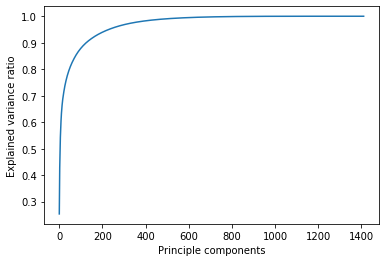

In [156]:
# generate a plot to show the accumulative vairances that were used by the components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')

In [163]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 150) # choose the top 150 components
generalPC = pca.fit_transform(scaled_data)
principalDf = pd.DataFrame(data=generalPC)

In [173]:
# Investigate the variance accounted for by 150 principal components.
sum(pca.explained_variance_ratio_[:150])

0.9149485932051785

Text(0.5, 0, 'Principle components')

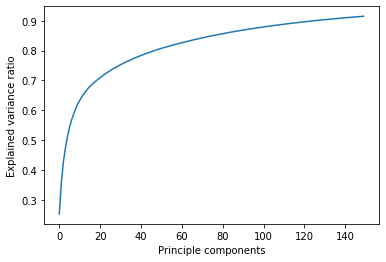

In [166]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')

In [168]:
# add activity and subject ID into the dimension-reduced dataframe
phone_data_feature_extracted_cleaned = pd.concat([principalDf,phone_data_feature_extracted_label.set_index(principalDf.index)], axis =1 )
phone_data_feature_extracted_cleaned.shape

(8187, 152)

### Step 6: Build a classification model and using accuracy and F1 score to evaluate the models

In [262]:
# define a function to loop over each user to split training and testing data
def split_train_test_data_for_each_subject(data):
    # get subject list
    subjects = data['subjectID'].unique()
    #accuracy_df = pd.DataFrame([])
    
    accuracy_df = pd.DataFrame([]) 
    f1_score_metrics = pd.DataFrame([])
  
        # Provide 'Address' as the column name 
    accuracy_df['names'] = [ 'LDA', 'KNN', 'CART', 'NB', 'SVM'] 
    f1_score_metrics['names'] = [ 'LDA', 'KNN', 'CART', 'NB', 'SVM']
    
    for subject in subjects:
        data_sub = data[data['subjectID'] == subject]

        # subset user data and divide into training and testing sets
        y_user = pd.Series(['user'] * (data_sub.shape[0])) # generate 'user' label
        X_user = data_sub.drop(['activity', 'subjectID'], axis = 1)

        X_user_train, X_user_test, y_user_train, y_user_test = train_test_split(X_user, y_user, test_size = 0.5)


        # split other uses
        #sampling with replacement
        subjects = np.arange(1600, 1651, 1).tolist()
        subjects.remove(subject)
        sampling_subjects = random.sample(subjects, 3)

        data_others = data[data['subjectID'].isin(sampling_subjects)]

        y_other = pd.Series(['imposter'] * (data_others.shape[0]))
        X_other = data_others.drop(['activity', 'subjectID'], axis = 1)

        X_other_train, X_other_test, y_other_train, y_other_test = train_test_split(X_other, y_other, test_size = 0.5)

        y_train = y_user_train.append(y_other_train)
        y_test =  y_user_test.append(y_other_test)

        X_train = X_user_train.append(X_other_train)
        X_test =  X_user_test.append(X_other_test)
        
        
        models = []
        #models.append(('LR', LogisticRegression()))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('KNN', KNeighborsClassifier()))
        models.append(('CART', DecisionTreeClassifier()))
        models.append(('NB', GaussianNB()))
        models.append(('SVM', SVC()))
        
        # evaluate each model by accuracy and f1 scorein turn
        accuracy_results = []
        f1_score_results = []

        #scoring = 'accuracy'
        #accuracy_df = pd.DataFrame([])

        for name, model in models:
            #print(model)
            model.fit(X_train,y_train)
            preds=model.predict(X_test)
            accuracy = accuracy_score(y_test, preds)
            accuracy_results.append(accuracy)
            

            f1 = f1_score(y_test, preds, pos_label = 'imposter')
            f1_score_results.append(f1)

            #names.append(name)

        accuracy_df[subject] = accuracy_results
        f1_score_metrics[subject] = f1_score_results

        """accuracy_df = pd.DataFrame(
        {'model': names,
         '1600': results
        })"""

    return accuracy_df, f1_score_metrics



### 6.1 Evaluate the model performance on features that were selected based on literature review

In [263]:
accuracy_df, f1_score_metrics = split_train_test_data_for_each_subject(phone_data_feature_selected)

In [264]:
accuracy_df

,names,1600,1601,1602,1603,1604,1605,1606,1607,1608,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,LDA,1.000000,0.986441,0.998369,1.000000,1.000000,0.993421,1.0,1.000000,1.000000,...,0.778157,1.000000,1.000000,0.992832,0.982353,1.000000,0.993994,0.996255,1.000000,0.989362
1,KNN,0.968116,0.861017,0.988581,0.944928,0.969697,0.934211,1.0,0.970190,0.974747,...,0.757679,0.968750,0.965854,0.992832,0.970588,0.979167,0.951952,1.000000,0.937313,0.975177
2,CART,1.000000,0.969492,0.991843,1.000000,0.993939,0.993421,1.0,0.989160,0.994949,...,0.730375,0.988281,1.000000,0.992832,0.982353,1.000000,0.972973,0.988764,0.976119,1.000000
3,NB,1.000000,0.823729,0.998369,1.000000,0.836364,0.993421,1.0,0.842818,0.969697,...,0.808874,0.968750,0.995122,0.989247,0.800000,1.000000,0.996997,0.880150,0.847761,0.719858
4,SVM,0.768116,0.722034,0.869494,0.695652,0.830303,0.654605,1.0,0.761518,0.929293,...,0.808874,0.968750,0.814634,0.860215,0.970588,0.973958,0.684685,0.921348,0.785075,0.847518


In [258]:
accuracy_df.to_csv('accuracy_df_manually_feature_selection.csv')

In [265]:
f1_score_metrics

,names,1600,1601,1602,1603,1604,1605,1606,1607,1608,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,LDA,1.000000,0.989529,0.999061,1.000000,1.000000,0.994949,1.0,1.000000,1.000000,...,0.832041,1.000000,1.000000,0.995851,0.990991,1.000000,0.995633,0.997912,1.000000,0.993684
1,KNN,0.979206,0.893506,0.993476,0.960663,0.971429,0.948980,1.0,0.979048,0.976959,...,0.821159,0.980676,0.978328,0.995851,0.985075,0.989362,0.965957,1.000000,0.955224,0.985138
2,CART,1.000000,0.976378,0.995314,1.000000,0.994152,0.994949,1.0,0.992424,0.995349,...,0.807786,0.992665,1.000000,0.995851,0.990991,1.000000,0.980392,0.993789,0.982609,1.000000
3,NB,1.000000,0.863158,0.999061,1.000000,0.862944,0.994949,1.0,0.876596,0.971429,...,0.848649,0.980676,0.996885,0.993763,0.886667,1.000000,0.997812,0.930435,0.892632,0.812352
4,SVM,0.868852,0.811060,0.930192,0.820513,0.831325,0.791252,1.0,0.857143,0.930693,...,0.850267,0.980676,0.893855,0.924855,0.985075,0.986807,0.812834,0.958084,0.861004,0.917466


In [266]:
f1_score_metrics.to_csv('f1_score_metrics_manually_feature_selection.csv')

### 6.2 Evaluate the model performance on features after PCA

In [267]:
accuracy_df_pca, f1_score_metrics_pca = split_train_test_data_for_each_subject(phone_data_feature_extracted_cleaned)

In [268]:
accuracy_df_pca

,names,1600,1601,1602,1603,1604,1605,1606,1607,1608,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,LDA,1.000000,1.000000,0.996737,1.000000,1.000000,1.000000,1.00000,0.997297,1.000000,...,1.0,1.000000,1.000000,0.996032,1.000000,1.000000,1.000000,1.000000,0.985030,1.000000
1,KNN,1.000000,1.000000,0.998369,1.000000,1.000000,1.000000,1.00000,0.989189,0.997183,...,1.0,1.000000,0.996764,0.996032,0.980769,0.977528,0.997368,0.986301,0.988024,0.992857
2,CART,0.944928,0.967066,0.954323,0.974026,0.985185,0.944928,0.99375,0.897297,0.988732,...,1.0,0.985423,0.899676,0.996032,0.992308,0.988764,0.957895,0.928082,0.925150,0.917857
3,NB,0.988406,0.976048,0.967374,0.980519,1.000000,0.982609,1.00000,0.967568,0.966197,...,1.0,0.985423,0.980583,0.996032,1.000000,1.000000,0.994737,0.986301,0.916168,0.928571
4,SVM,1.000000,1.000000,0.996737,1.000000,1.000000,1.000000,1.00000,0.997297,1.000000,...,1.0,1.000000,1.000000,0.996032,0.992308,1.000000,1.000000,0.986301,0.997006,0.996429


In [270]:
accuracy_df_pca.to_csv('accuracy_df_pca.csv')

In [269]:
f1_score_metrics_pca

,names,1600,1601,1602,1603,1604,1605,1606,1607,1608,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,LDA,1.000000,1.000000,0.998124,1.000000,1.000000,1.000000,1.000000,0.998117,1.000000,...,1.0,1.000000,1.000000,0.997658,1.000000,1.000000,1.000000,1.000000,0.989059,1.000000
1,KNN,1.000000,1.000000,0.999061,1.000000,1.000000,1.000000,1.000000,0.992509,0.998110,...,1.0,1.000000,0.998117,0.997658,0.990291,0.988506,0.998185,0.992509,0.991342,0.995798
2,CART,0.963671,0.976139,0.973635,0.980392,0.989418,0.960499,0.995833,0.929104,0.992395,...,1.0,0.991394,0.941620,0.997658,0.996063,0.994186,0.970480,0.960748,0.946237,0.951782
3,NB,0.992481,0.982833,0.981343,0.985075,1.000000,0.987552,1.000000,0.977860,0.977695,...,1.0,0.991453,0.988806,0.997658,1.000000,1.000000,0.996377,0.992481,0.941667,0.959514
4,SVM,1.000000,1.000000,0.998124,1.000000,1.000000,1.000000,1.000000,0.998110,1.000000,...,1.0,1.000000,1.000000,0.997658,0.996094,1.000000,1.000000,0.992509,0.997821,0.997895


In [271]:
f1_score_metrics_pca.to_csv('f1_score_metrics_pca.csv')

### Conclusion: From the results above, using PCA to do feature reduction will generate much better results than manually selecting features.